In [ ]:
%cd /content

# download the predictive coding repository
!git clone https://github.com/jgornet/predictive-coding.git
%cd predictive-coding/notebooks


In [1]:
from pathlib import Path
import os
from glob import glob
import re

import torch
import torch.optim
import torch.nn.functional as F

import seaborn as sns

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import matplotlib

import numpy as np

from IPython.display import display, clear_output
from PIL import Image
from tqdm.auto import tqdm

from torchvision.io import write_video
from torchvision.transforms import ToTensor, Normalize

from predictive_coding.models.models import PredictiveCoder
from predictive_coding.dataset import EnvironmentDataset, collate_fn


# Predictive coding

In this Google Colab notebook, we apply a pre-trained predictive coding neural network to a dataset containing observations from an agent navigating the Minecraft environment. First, we load the predictive coding neural network. Next, we import the validation dataset that captures episodes of an agent moving through various terrains in Minecraft. Our goal is to utilize the network's attention-based decoder to generate latent vectors from the data. These vectors provide a condensed representation of the agent's interactions within the environment.


In [2]:
device = 'cuda:0'

# Initialize the predictive coding architecture
model = PredictiveCoder(in_channels=3, out_channels=3, layers=[2, 2, 2, 2], seq_len=10, num_skip=3)
model = model.to(device)

ckpt = torch.load('../weights/predictive_coding.ckpt', map_location=device)
model.load_state_dict(ckpt)
model.eval()
clear_output()


In [3]:
# Load the environment observations
dataset = EnvironmentDataset(Path("../datasets/val-dataset"))
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True,
)


In [19]:
# Generate the latent vectors from the predictive coding neural network
latents = []
positions = []
for batch_idx, batch in enumerate(tqdm(dataloader)):
    images, actions, states = batch
    B, L, C, H, W = images.shape
    images = images.to(device).reshape(B*L, C, H, W)
    states = states.reshape(B*L, -1)

    with torch.no_grad():
        features = model.encoder(images)
        features = [f.reshape(B, L, f.shape[1], f.shape[2], f.shape[3]) for f in features]
        features = [attention(feature, feature, feature, model.mask)[0] for attention, feature in zip(model.attention, features)]
        features = [f.reshape(B*L, f.shape[2], f.shape[3], f.shape[4]) for f in features]
        codes = model.decoder.get_codes(features)
        latents.append(codes[1].cpu())
        positions.append(states)

latents = torch.cat(latents, dim=0).cpu().numpy()
positions = torch.cat(positions, dim=0).cpu().numpy()


  0%|          | 0/130 [00:00<?, ?it/s]

Exploring further, we discern that the latent space of the predictive coder effectively captures the local distances between physical positions in the environment. By examining every agent's path, we compute local pairwise distances both in real space and within the coder's latent space considering a window of 100 time points.  An intriguing observation is the correlation between latent space distances and actual physical distances, which can be modeled with the equation \(𝑑(𝑧,𝑧′) = 𝛼 log(∥𝑥−𝑥′+𝜖∥)+𝛽, 𝜖 ∼ 𝒩(0,𝜎)\).

Lastly, as a control measure, we reshuffle the physical positions and compute latent distances based on this shuffled set. Our model's distribution aligns closely with the predictive coder's distribution, boasting a Kullback-Leibler divergence (DKL) of just 0.429 bits. In contrast, the shuffled or null distribution diverges significantly from the coder's distribution, displaying a DKL value of 2.441 bits.


In [20]:
def get_dist(array, L=50, offset=300, neighborhood=L // 2 + 1):
    dist = np.zeros((L+1) * L // 2)
    for shift in np.arange(1, L // 2):
        dist[(shift-1)*neighborhood:shift*neighborhood] = np.sqrt(
            np.sum((array[offset:offset+neighborhood] - np.roll(array[offset:offset+neighborhood], shift - neighborhood // 2, axis=0))**2, axis=1)
        )
        
    dist = dist[dist != 0]
        
    return dist


/tmp/ipykernel_234154/3262072531.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=actual_dist[idx][smp_idx], y=0.26*(latent_dist[idx][smp_idx] - latent_dist.min()), shade=True, label="Predictive Coding", alpha=0.5, clip=[0, 50])
/tmp/ipykernel_234154/3262072531.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=actual_dist[idx][smp_idx], y=0.53*(latent_dist[idx][smp_idx] - latent_dist.min()), shade=True, label="Random Pairs", alpha=0.5, clip=[0, 50], color=plt.cm.Dark2(0))
/tmp/ipykernel_234154/3262072531.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=actual_dist[idx][smp_idx], y=2.3*np.log(latent_dist[

Text(0, 0.5, 'Latent distance (a.u.)')

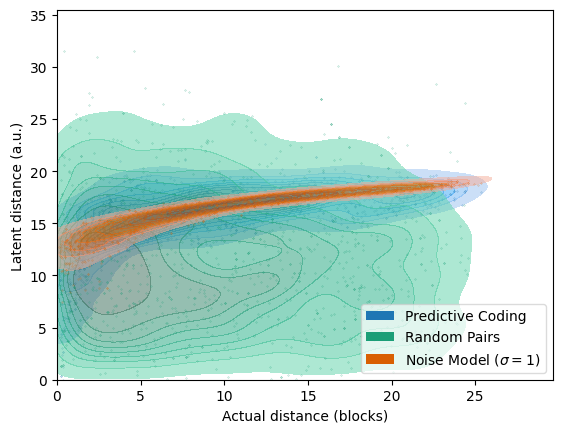

In [22]:
L = 10000
offset = 100
neighborhood = 90
cutoff = 0
N = len(latents)
latent_dist = get_dist(latents.reshape((N, -1)), L=L, offset=offset, neighborhood=neighborhood)
actual_dist = get_dist(positions[:, :2], L=L, offset=offset, neighborhood=neighborhood)

idx = np.argsort(actual_dist)

smp_idx = np.random.randint(len(actual_dist), size=10000)
sns.kdeplot(x=actual_dist[idx][smp_idx], y=0.26*(latent_dist[idx][smp_idx] - latent_dist.min()), shade=True, label="Predictive Coding", alpha=0.5, clip=[0, 50])
plt.scatter(actual_dist[idx][smp_idx][::10], 0.26*(latent_dist[idx][smp_idx][::10] - latent_dist.min()), s=0.05, alpha=0.7, zorder=1, color=plt.cm.tab10(0))

shuffle_idx = np.random.choice(len(positions), replace=False, size=len(positions))
null = positions[shuffle_idx]
latent_dist = get_dist(null[:, :2].reshape((N, -1)), L=L, offset=offset, neighborhood=neighborhood)
actual_dist = get_dist(positions[:, :2], L=L, offset=offset, neighborhood=neighborhood)

idx = np.argsort(actual_dist)

smp_idx = np.random.randint(len(actual_dist), size=10000)
sns.kdeplot(x=actual_dist[idx][smp_idx], y=0.53*(latent_dist[idx][smp_idx] - latent_dist.min()), shade=True, label="Random Pairs", alpha=0.5, clip=[0, 50], color=plt.cm.Dark2(0))
plt.scatter(actual_dist[idx][smp_idx][::10], 0.53*(latent_dist[idx][smp_idx][::10] - latent_dist.min()), s=0.05, alpha=0.7, color=plt.cm.Dark2(0), zorder=1)

latent_dist = get_dist(positions[:, :2] + np.random.randn(*positions[:, :2].shape).reshape((N, -1)), L=L, offset=offset, neighborhood=neighborhood)
actual_dist = get_dist(positions[:, :2], L=L, offset=offset, neighborhood=neighborhood)

idx = np.argsort(actual_dist)

smp_idx = np.random.randint(len(actual_dist), size=10000)
sns.kdeplot(x=actual_dist[idx][smp_idx], y=2.3*np.log(latent_dist[idx][smp_idx])+11.4, shade=True, label="Noise Model ($\sigma=1$)", alpha=0.5, clip=[0, 50], color=plt.cm.Dark2(1))
plt.scatter(actual_dist[idx][smp_idx][::10], 2.3*np.log(latent_dist[idx][smp_idx][::10])+11.4, s=0.05, alpha=0.7, color=plt.cm.Dark2(1), zorder=1)

plt.legend([Patch(facecolor=plt.cm.tab10(0)), Patch(facecolor=plt.cm.Dark2(0)), Patch(facecolor=plt.cm.Dark2(1))],
           ["Predictive Coding", "Random Pairs", "Noise Model ($\sigma = 1$)"],
           loc='lower right', framealpha=0.7, shadow=False)

plt.xlabel('Actual distance (blocks)')
plt.ylabel('Latent distance (a.u.)')


To quantify the positional data inherent in the predictive coder, we employ a neural network designed to predict the agent's position based on these latent units. The prediction error of the neural network, defined as $𝐸(x,\hat{x}) = \Vert \hat{x}−x \Vert_{\ell_2}$, serves as an indirect metric for gauging the positional information retained by the predictive coder.

For a comprehensive assessment, we introduce two distinct position prediction models to set bounds on the prediction error. The first model, which acts as a lower bound, incorporates the agent's true position with a slight Gaussian noise $\hat{x} = x + 𝜖, 𝜖 ∼ 𝒩(0,𝜎)$. For the upper bound, a model is constructed that reshuffles the agent's genuine position without any repetitions. To draw contrasts, the predictive coder's prediction errors are juxtaposed with these baseline models using histograms.

Results highlight the proficiency of the predictive coder in encoding spatial positions. A noteworthy mention is its mean error of 5.04 lattice units and that over 80% of its samples deviate by less than 7.3 lattice units. Comparatively, the Gaussian noise model (with \(𝜎 = 4\)) has a slightly better mean error of 4.98 lattice units, and its samples mostly have an error below 7.12 lattice units. However, the shuffle model drastically underperforms with an average error of 15.87 lattice units and most samples exceeding an error of 22.24 lattice units.


In [17]:
folds = glob('../datasets/pc-images/*')
images = torch.empty(len(folds), 10, 3, 64, 64)
actions = torch.empty(len(folds), 10, 2)
positions = torch.zeros(len(folds), 2)
for idx, fold in enumerate(folds):
    x, y = re.findall('../datasets/pc-images/(.*)_(.*)', fold)[0]
    action = torch.from_numpy(np.load(f'{fold}/actions.npy'))
    actions[idx] = action
    positions[idx] = torch.from_numpy(np.load(f'{fold}/states.npy'))[-1, :2]
    
    for tidx in range(10):
        if not os.path.exists(f'{fold}/{tidx}.png'):
            images[idx, tidx] = torch.zeros(3, 64, 64)
            print(tidx, x, y)
            continue

        image = Image.open(f'{fold}/{tidx}.png')
        image = Normalize([121.6697, 149.3242, 154.9510], [40.7521,  47.7267, 103.2739])(ToTensor()(image))
    
        images[idx, tidx] = image
    

In [18]:
latents = []

model = model.to('cuda:0')

bsz = 100
for idx in range(len(images) // bsz + 1):
    batch = images[bsz*idx:bsz*(idx+1)].to('cuda:0')
    B, L, C, H, W = batch.shape
    batch = batch.to("cuda:0").reshape(B*L, C, H, W)
    act = actions[bsz*idx:bsz*(idx+1)].to("cuda:0").reshape(B*L, -1)
    
    with torch.no_grad():
        features = model.encoder(batch)
        codes = model.decoder.get_codes(features)
        latents.append(codes[1].cpu().reshape(B, L, -1, 8, 8))
        
latents = torch.cat(latents, dim=0)


In [19]:
from torch import nn
import torch
import torch.nn.functional as F

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)

net = nn.Sequential(
    nn.Conv2d(128, 256, 3, padding=1),
    nn.MaxPool2d(2),
    Lambda(lambda x: x.reshape(-1, 256*4*4)),
    nn.Linear(64*8*8, 64),
    nn.ReLU(),
    nn.Linear(64, 2)
)

net = net.to("cuda:0")
    
optimizer = torch.optim.AdamW(net.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.1)


In [20]:
batch_size = 512
for epoch in range(10000):
    batch_idx = np.arange(0, len(latents))
    np.random.shuffle(batch_idx)
    batch_idx = batch_idx[:len(batch_idx) // batch_size * batch_size].reshape(-1, batch_size)
    for it, idx in enumerate(batch_idx):
        optimizer.zero_grad()
        batch = latents[idx, -1].to("cuda:0")
        pos = positions[idx, :2].to("cuda:0") / 30
        pred = net(batch)
        loss = F.mse_loss(pred, pos)
        loss.backward()
        optimizer.step()
        if it % 100:
            with torch.no_grad():
                pred = net(latents[:1000, -1].to("cuda:0")).cpu() * 30
                print(F.mse_loss(pred, positions[:1000, :2]), end='\r')
    scheduler.step()
        

In [21]:
with torch.no_grad():
    batch = latents[:, -1].to("cuda:0")
    pc_pos = positions[:, :2].cpu() / 30
    pc_pred = net(batch).cpu()
    pc = torch.linalg.norm(pc_pred * 30 - positions[:, :2], dim=1).cpu().numpy()


In [22]:
null = np.linalg.norm(np.random.randint(30, size=(2, 1000)) - np.random.randint(30, size=(2, 1000)), axis=0)
grid = np.stack(np.mgrid[-20:20,-30:35])
rand = np.linalg.norm(np.random.randn(*grid.shape), axis=0).reshape(-1)


NameError: name 'scale' is not defined

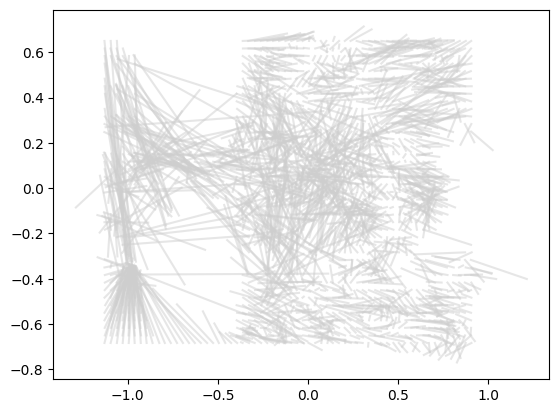

In [23]:
from matplotlib.lines import Line2D

for idx in range(len(pc_pos)):
    plt.plot([-pc_pred[idx, 1], -pc_pos[idx, 1]], [pc_pred[idx, 0], pc_pos[idx, 0]], alpha=0.5, color=plt.cm.Greys(0.3), zorder=-1)
act = plt.scatter(-pc_pos[:, 1], pc_pos[:, 0], s=1*scale, c=plt.cm.Greys(0.6), label='Actual')
p = plt.scatter(-pc_pred[:, 1], pc_pred[:, 0], s=1*scale, c=plt.cm.Blues(0.75), label='Predicted')
plt.gca().set_aspect("equal")
plt.xlabel("x (lattice units)")
plt.ylabel("y (lattice units)")
plt.legend([Line2D([0], [0], marker='o', color=plt.cm.Greys(0.6), markersize=2, linestyle="None"), 
            Line2D([0], [0], marker='o', color=plt.cm.Blues(0.75), markersize=2, linestyle="None"),
            Line2D([0], [0], color=plt.cm.Greys(0.5), lw=2.0)], ['Actual', 'Predicted', 'Error'], 
           loc='upper right', bbox_to_anchor=(1.1, 1.0), prop=font)


In [ ]:
import seaborn as sns
from matplotlib.lines import Line2D

sns.histplot(pc, kde=True, stat="density", label="Predictive Coding")
sns.kdeplot(null, fill=True, label="Random Pairs", color=plt.cm.Dark2(0))
sns.kdeplot(rand, fill=True, label="Noise Model ($\sigma=1$)", color=plt.cm.Dark2(1))
plt.xlabel("Error ($\Vert x - \hat{x}(z) \Vert_{\ell_2}$) (lattice units)")
plt.legend()
